In [1]:
import sklearn.metrics
import torch
import torch.nn as nn
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import importlib
import src.params as params
import src.model as model
import src.main as main
import src.dataloader as dataloader
importlib.reload(dataloader)
importlib.reload(model)
import torch.nn.functional as F

In [3]:
args = params.get_args("../config/system_a.yaml")
data,kpi_name = main.get_cmdb(args)
train,valid,test = main.get_dataset(args)
basic = model.Basic(args, data, kpi_name)

Loading preprocessed data from /home/junetheriver/code/aiops/workdir/system_a/data_pre.pkl
Loaded ground truth from gt_pre.pkl
[140  79  24  39  27  21  23  36]
metric_num: 2152, kpi_num: 121, torch.Size([38880, 2153])


In [8]:
basic.data.shape

torch.Size([38880, 2153])

In [27]:
metric_dt = {}
for l in range(8):
    metric_dt[l] = set()
for x,y in train:
    cmdb_id, timestamp = x
    cmdb_idx = basic.cmdb_idx[cmdb_id]
    y = np.argmax(y)
    a = model.get_kpi_at_time(basic.data, cmdb_idx, timestamp, 10)
    b = model.get_kpi_at_time(basic.data, cmdb_idx, timestamp-10, 20)
    for i in range(basic.kpi_num):
        p = stats.ks_2samp(a[:,i], b[:,i])[1]
        if p < 0.05:
            # print(p)
            metric_dt[y].add(list(basic.kpi_set)[i])

In [34]:
import pandas as pd
max_len = 0
for i in metric_dt.values():
    if max_len < len(i):
        max_len = len(i)
for k, i in metric_dt.items():
    i = list(i)
    while len(i) < max_len:
        i.append('')
    i.sort()
    i.reverse()
    metric_dt[k] = i

In [35]:
df = pd.DataFrame(metric_dt)
df.to_csv("../../workdir/system_a/kstest_kpi.csv")

In [36]:
from sklearn import tree

In [37]:

dataset = dataloader.MyDataset(args)

Loaded ground truth from gt_pre.pkl
[140  79  24  39  27  21  23  36]


In [57]:
X = [np.array(basic.data[int(x[1]), :2152]) for x, y in dataset]
Y = [np.argmax(y) for x, y in dataset]

In [60]:
len(X) * 0.8

311.20000000000005

In [87]:
clf = tree.DecisionTreeClassifier(max_depth=9)
X_train = X[:311]
Y_train = Y[:311]
clf = clf.fit(X_train, Y_train)
X_test = X[311:]
Y_test = Y[311:]
Y_predict = clf.predict(X_test)
import sklearn
print(sklearn.metrics.accuracy_score(Y_test, Y_predict))
sklearn.metrics.f1_score(Y_test, Y_predict, average=None)

0.2948717948717949


array([0.45714286, 0.27027027, 0.        , 0.14285714, 0.        ,
       0.        , 0.        , 0.125     ])

[Text(0.48719507334183676, 0.9705882352941176, 'X[848] <= 4139.0\ngini = 0.807\nsamples = 311\nvalue = [106, 63, 24, 33, 20, 19, 23, 23]'),
 Text(0.1916454081632653, 0.9117647058823529, 'X[789] <= 11450.255\ngini = 0.865\nsamples = 99\nvalue = [15, 14, 16, 16, 10, 9, 13, 6]'),
 Text(0.13903061224489796, 0.8529411764705882, 'X[1610] <= 5.135\ngini = 0.375\nsamples = 8\nvalue = [0, 0, 0, 2, 0, 0, 6, 0]'),
 Text(0.1288265306122449, 0.7941176470588235, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 0, 0, 0, 0, 6, 0]'),
 Text(0.14923469387755103, 0.7941176470588235, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 2, 0, 0, 0, 0]'),
 Text(0.24426020408163265, 0.8529411764705882, 'X[1140] <= 0.225\ngini = 0.862\nsamples = 91\nvalue = [15, 14, 16, 14, 10, 9, 7, 6]'),
 Text(0.16964285714285715, 0.7941176470588235, 'X[217] <= 0.47\ngini = 0.829\nsamples = 50\nvalue = [3, 6, 15, 8, 4, 5, 7, 2]'),
 Text(0.11479591836734694, 0.7352941176470589, 'X[1732] <= 15.5\ngini = 0.741\nsamples = 35\nvalue = [1, 6, 15, 

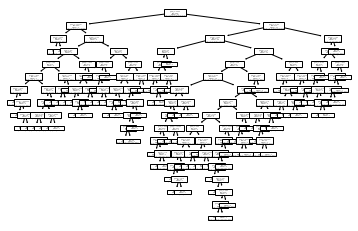

In [76]:
tree.plot_tree(clf)